In [1]:
import os
import re
from pathlib import Path

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid', palette='muted')
colors = list(sns.color_palette('muted').as_hex())
colors

['#4878d0',
 '#ee854a',
 '#6acc64',
 '#d65f5f',
 '#956cb4',
 '#8c613c',
 '#dc7ec0',
 '#797979',
 '#d5bb67',
 '#82c6e2']

In [2]:
base_path = os.path.dirname(os.getcwd())
base_path = Path(base_path) / 'bes-edgeml-models/turbulence_regime_classification'

In [3]:
df = pd.read_excel(f'{base_path}/confinement_database.xlsx')
df.head(10)

,shot,tstart (ms),tstop (ms),L-mode,H-mode,QH-mode,WP QH-mode,Notes
0,149992.0,2540.0,2635.0,1.0,NaN,NaN,NaN,NaN
1,149992.0,2638.0,3200.0,NaN,1.0,NaN,NaN,"ELM-free, then ELMy"
2,149992.0,4038.0,4125.0,1.0,NaN,NaN,NaN,NaN
3,149992.0,4136.0,4500.0,NaN,1.0,NaN,NaN,"ELM-free, then ELMy"
4,149993.0,1100.0,1900.0,1.0,NaN,NaN,NaN,long L-mode due to failed LH transition
5,149993.0,2540.0,2635.0,1.0,NaN,NaN,NaN,NaN
6,149993.0,2650.0,3400.0,NaN,1.0,NaN,NaN,"ELM-free, then ELMy"
7,149993.0,4050.0,4165.0,1.0,NaN,NaN,NaN,NaN
8,149993.0,4172.0,4975.0,NaN,1.0,NaN,NaN,"ELM-free, then ELMy"
9,149994.0,1340.0,1900.0,1.0,NaN,NaN,NaN,long L-mode due to failed LH transition


In [7]:
df.fillna(value=0, inplace=True)
df.head(10)

,shot,tstart (ms),tstop (ms),L-mode,H-mode,QH-mode,WP QH-mode,Notes
0,149992.0,2540.0,2635.0,1.0,0.0,0.0,0.0,0
1,149992.0,2638.0,3200.0,0.0,1.0,0.0,0.0,"ELM-free, then ELMy"
2,149992.0,4038.0,4125.0,1.0,0.0,0.0,0.0,0
3,149992.0,4136.0,4500.0,0.0,1.0,0.0,0.0,"ELM-free, then ELMy"
4,149993.0,1100.0,1900.0,1.0,0.0,0.0,0.0,long L-mode due to failed LH transition
5,149993.0,2540.0,2635.0,1.0,0.0,0.0,0.0,0
6,149993.0,2650.0,3400.0,0.0,1.0,0.0,0.0,"ELM-free, then ELMy"
7,149993.0,4050.0,4165.0,1.0,0.0,0.0,0.0,0
8,149993.0,4172.0,4975.0,0.0,1.0,0.0,0.0,"ELM-free, then ELMy"
9,149994.0,1340.0,1900.0,1.0,0.0,0.0,0.0,long L-mode due to failed LH transition


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   shot         41 non-null     float64
 1   tstart (ms)  41 non-null     float64
 2   tstop (ms)   41 non-null     float64
 3   L-mode       41 non-null     float64
 4   H-mode       41 non-null     float64
 5   QH-mode      41 non-null     float64
 6   WP QH-mode   41 non-null     float64
 7   Notes        41 non-null     object 
dtypes: float64(7), object(1)
memory usage: 2.7+ KB


## A few things to confirm:
- Are `tstart` and `tstop` just the indexes for both time and signals or should I shift them by 800?
- Does it make sense to multiply `tstart` and `tstop` by 1000 to retrieve corresponding signals?

In [8]:
data = []
for f in os.listdir(f'{base_path}/data'):
    print(f'Filename: {f}')
    try:
        shot_data = h5py.File(f'{base_path}/data/{f}')
        shot_num = re.findall(r'\d+', f)[0]
        print(f'Shot number: {shot_num}')
        signals = np.array(shot_data['signals'])
        print(signals.shape)
        signals = signals.transpose()
        print(signals.shape)
        time = np.array(shot_data['time'])
        print(f'Signals: {signals.shape}')
        print(f'Time: {time.shape}')
        shot_df = df[df['shot'] == float(shot_num)]
        label = []
        signal = []
        for i, row in shot_df.iterrows():
            tstart = row['tstart (ms)']
            tstop = row['tstop (ms)']
            start = np.where(time == tstart)[0][0]
            stop = np.where(time == tstop)[0][0]
            print(f'Start index: {start}, stop index: {stop}')
            tmode_signal = signals[start:stop]
            signal_df = pd.DataFrame(
                {f'Ch_{j+1}':tmode_signal[:,j] for j in range(tmode_signal.shape[1])},
                columns=[f'Ch_{j+1}' for j in range(tmode_signal.shape[1])]
            )
            label_vec = row[['L-mode', 'H-mode', 'QH-mode', 'WP QH-mode']].to_numpy(dtype=int)
            signal_df['mode'] = np.argmax(label_vec)
            signal.append(signal_df)
        # signal_df['mode'] = label
        signal = pd.concat(signal, axis=0)
        signal['shot_num'] = shot_num
        print('Target value counts:')
        print(signal['mode'].value_counts())
        data.append(signal)
    except FileNotFoundError:
        'HDF5 file not found.'
data = pd.concat(data, axis=0)
data.head()

Filename: bes_signals_184826.hdf5
Shot number: 184826
(64, 6291456)
(6291456, 64)
Signals: (6291456, 64)
Time: (6291456,)
Start index: 1758000, stop index: 1778000
Start index: 1808000, stop index: 1828000
Start index: 1858000, stop index: 1878000
Start index: 1908000, stop index: 1928000
Start index: 1958000, stop index: 1978000
Start index: 2008000, stop index: 2028000
Start index: 2058000, stop index: 2078000
Start index: 2108000, stop index: 2128000
Start index: 2158000, stop index: 2178000
Start index: 2208000, stop index: 2228000
Start index: 2258000, stop index: 2278000
Start index: 2308000, stop index: 2328000
Start index: 2358000, stop index: 2378000
Start index: 2408000, stop index: 2428000
Target value counts:
3    280000
Name: mode, dtype: int64
Filename: bes_signals_149995_labeled.hdf5
Shot number: 149995
(64, 5242880)
(5242880, 64)
Signals: (5242880, 64)
Time: (5242880,)
Start index: 500000, stop index: 1150000
Start index: 1750000, stop index: 1940000
Start index: 196000

KeyboardInterrupt: 

In [7]:
def get_start_stop(tstart:float, tstop:float, time:np.ndarray):
    return np.where(time == tstart)[0][0], np.where(time == tstop)[0][0]

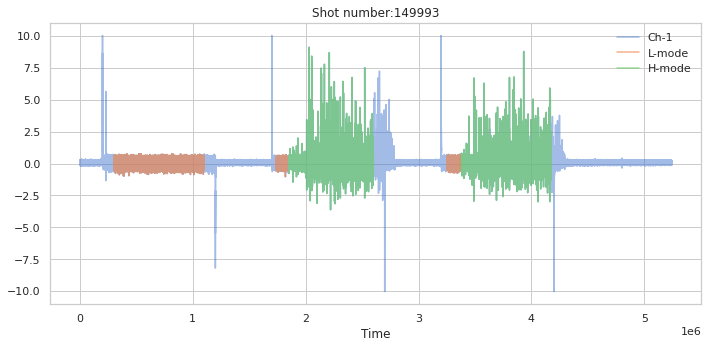

In [8]:
shot_number = 149993
f = h5py.File(f'{base_path}/data/bes_signals_{shot_number}.hdf5')
ch_1_signal = np.array(f['signals']).transpose()[:, 0]
time = np.array(f['time'])

# l-mode
tstart_l1 = 1100.0
tstop_l1 = 1900.0
start_l1, stop_l1 = get_start_stop(tstart_l1, tstop_l1, time)

# l-mode
tstart_l2 = 2540.0
tstop_l2 = 2635.0
start_l2, stop_l2 = get_start_stop(tstart_l2, tstop_l2, time)

# h-mode
tstart_h1 = 2650.0
tstop_h1 = 3400.0
start_h1, stop_h1 = get_start_stop(tstart_h1, tstop_h1, time)

# l-mode
tstart_l3 = 4050.0
tstop_l3 = 4165.0
start_l3, stop_l3 = get_start_stop(tstart_l3, tstop_l3, time)

# h-mode
tstart_h2 = 4172.0
tstop_h2 = 4975.0
start_h2, stop_h2 = get_start_stop(tstart_h2, tstop_h2, time)

f.close()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(len(ch_1_signal)), ch_1_signal, color=colors[0], label='Ch-1', alpha=0.5)
ax.plot(range(start_l1, stop_l1), ch_1_signal[start_l1:stop_l1], color=colors[1], label='L-mode', alpha=0.65)
ax.plot(range(start_h1, stop_h1), ch_1_signal[start_h1:stop_h1], color=colors[2], label='H-mode', alpha=0.65)
ax.plot(range(start_l2, stop_l2), ch_1_signal[start_l2:stop_l2], color=colors[1], alpha=0.65)
ax.plot(range(start_h2, stop_h2), ch_1_signal[start_h2:stop_h2], color=colors[2], alpha=0.65)
ax.plot(range(start_l3, stop_l3), ch_1_signal[start_l3:stop_l3], color=colors[1], alpha=0.65)
ax.legend(frameon=False)
ax.set_xlabel('Time')
ax.set_title(f'Shot number:{shot_number}')
plt.tight_layout()
plt.show()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5781000 entries, 0 to 363999
Data columns (total 66 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Ch_1      float64
 1   Ch_2      float64
 2   Ch_3      float64
 3   Ch_4      float64
 4   Ch_5      float64
 5   Ch_6      float64
 6   Ch_7      float64
 7   Ch_8      float64
 8   Ch_9      float64
 9   Ch_10     float64
 10  Ch_11     float64
 11  Ch_12     float64
 12  Ch_13     float64
 13  Ch_14     float64
 14  Ch_15     float64
 15  Ch_16     float64
 16  Ch_17     float64
 17  Ch_18     float64
 18  Ch_19     float64
 19  Ch_20     float64
 20  Ch_21     float64
 21  Ch_22     float64
 22  Ch_23     float64
 23  Ch_24     float64
 24  Ch_25     float64
 25  Ch_26     float64
 26  Ch_27     float64
 27  Ch_28     float64
 28  Ch_29     float64
 29  Ch_30     float64
 30  Ch_31     float64
 31  Ch_32     float64
 32  Ch_33     float64
 33  Ch_34     float64
 34  Ch_35     float64
 35  Ch_36     float64
 36  Ch_37    

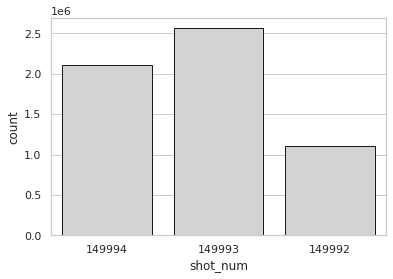

In [10]:
sns.countplot(x='shot_num', data=data, fc='lightgray', edgecolor='k')
plt.show()

In [11]:
import h5py
turb_modes = {0:'L_mode', 1:'H_mode', 2:'QH_mode', 3:'WP_QH_mode'}
features = [col for col in data.columns if col not in ['shot_num', 'mode']]
shot_nums = data.shot_num.unique().tolist()
print(f'Shots: {shot_nums}')
with h5py.File(f'{base_path}/processed_data/test_datafile.hdf5', 'w') as f:
    for shot in shot_nums:
        print(f'Processing shot number: {shot}')
        grp = f.create_group(str(shot))
        df = data[data['shot_num'] == shot]
        for mode in df['mode'].unique().tolist():
            turb_data = df[df['mode'] == mode][features].values
            dset = grp.create_dataset(turb_modes[mode], data=turb_data, dtype=np.float32)

Shots: ['149994', '149993', '149992']
Processing shot number: 149994
Processing shot number: 149993
Processing shot number: 149992


In [12]:
with h5py.File(f'{base_path}/processed_data/test_datafile.hdf5', 'r') as f:
    for k in f.keys():
        print(f'Shot number: {k}')
        for k1 in f[k].keys():
            print(f'Mode: {k1}')
            print(np.array(f[k][k1]).shape)

Shot number: 149992
Mode: H_mode
(926000, 64)
Mode: L_mode
(182000, 64)
Shot number: 149993
Mode: H_mode
(1553000, 64)
Mode: L_mode
(1010000, 64)
Shot number: 149994
Mode: L_mode
(2110000, 64)
